In [1]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import tensorflow_hub as hub
from tqdm import tqdm
import nltk
from nltk import word_tokenize
from sklearn.preprocessing import LabelEncoder
nltk.download('punkt')
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!pip install contractions
import contractions

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
train_data = pd.read_csv('TrainData.csv').values
test = pd.read_csv('TestData_Inputs.csv').values
train_data[:10]

array([['worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom

In [3]:
import string
punctuation = '!"#$%&\'()*+,-/:;<=>?@[\]^_`{|}~'
table = str.maketrans('','',punctuation)

w = "wekfwknefkf//*1.,..[][']]['"
w.translate(table)
word_tokenize('helllo k.')

['helllo', 'k', '.']

In [4]:
np.random.seed(11)
train_d = train_data[:,0]
train_l = train_data[:,1]
test_d = test[:,1]
#test_l = test[:,1]
print(train_d.shape)
temp = list(zip(train_d, train_l))
np.random.shuffle(temp)
train_d, train_l = zip(*temp)

(1490,)


In [5]:
punctuation = '!"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~'
stop_words = set(['i','am','re','are','be','so','or','a','an','as','he','she','his','her','the','there','here','and','but','other','on','in','to','of','up','down','after','before','we','they','has','have', 'was','were','is','','it','how','that','at','go','is','do','will','shall','ve','if','may','might','by','s','o','d','t','my','might','all','out','for','ll'])
table = str.maketrans('','',punctuation)
train_p = []
test_p = []
train_tokens = []
for paragraph in train_d:
  tokens = contractions.fix(paragraph)
  temp = []
  for sentence in nltk.tokenize.sent_tokenize(tokens):
    if len(sentence)==0:
        continue
    #tokens = word_tokenize(tokens)
    token = [w.translate(table)  for w in sentence.split(' ') if len(w)>0]
    token = [w for w in token if w.isalpha()]
    token = [w for w in token if not w in stop_words]
    #print(token)
    temp.append(token)
    train_tokens += token
  train_p.append(temp)

for paragraph in test_d:
  tokens = contractions.fix(paragraph)
  temp = []
  for sentence in nltk.tokenize.sent_tokenize(tokens):
    if len(sentence)==0:
        continue
    #tokens = word_tokenize(tokens)
    token = [w.translate(table)  for w in sentence.split(' ') if len(w)>0 ]

    token = [w for w in token if w.isalpha()]
    token = [w for w in token if not w in stop_words]
    #print(token)
    temp.append(token)
  test_p.append(temp)

In [6]:
train_tokens[:20]

['us',
 'critics',
 'laud',
 'comedy',
 'sideways',
 'road',
 'trip',
 'comedy',
 'sideways',
 'had',
 'more',
 'praise',
 'heaped',
 'two',
 'us',
 'critics',
 'associations',
 'adding',
 'honours',
 'already']

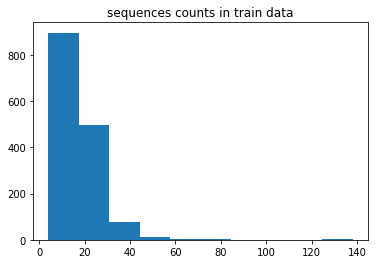

maximum sequence length: 138


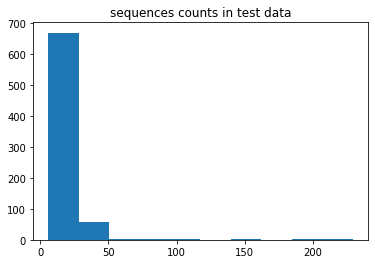

maximum sequence length: 229


In [7]:
plt.title('sequences counts in train data')
plt.hist([len(t) for t in train_p])
plt.show()
print(f"maximum sequence length: {max([len(t) for t in train_p])}")

plt.title('sequences counts in test data')
plt.hist([len(t) for t in test_p])
plt.show()
print(f"maximum sequence length: {max([len(t) for t in test_p])}")

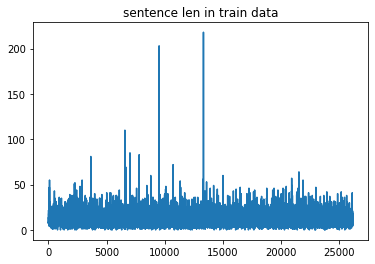

maximum sentence length: 218


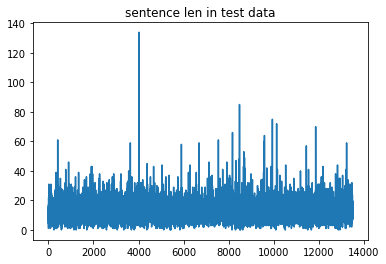

maximum sentence length: 134


In [8]:
plt.title('sentence len in train data')
hist = []
for paragraph in train_p:
  hist+=[len(t) for t in paragraph]
plt.plot(hist)
plt.show()
print(f"maximum sentence length: {max(hist)}")

plt.title('sentence len in test data')
hist = []
for paragraph in test_p:
  hist+=[len(t) for t in paragraph]
plt.plot(hist)
plt.show()
print(f"maximum sentence length: {max(hist)}")

In [9]:
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(train_tokens)
X_tok_train = [tokenizer.texts_to_sequences(paragraph) for paragraph in train_p]
X_tok_test = [tokenizer.texts_to_sequences(paragraph) for paragraph in test_p]
word_index = tokenizer.word_index
print("unique tokens except pad_token- "+str(len(word_index)))
vocab_size = len(tokenizer.word_index) + 1  #  pad_token at 0th index
print('vocab_size - '+str(vocab_size))
max_length = 25
X_padded_lines_train = [pad_sequences(paragraph, maxlen=max_length, padding='post') for paragraph in X_tok_train]
X_padded_lines_test = [pad_sequences(paragraph, maxlen=max_length, padding='post') for paragraph in X_tok_test]
#create word list from token using utf8 encoding 
#word_list = [word for words in processedLines for word in words]

unique tokens except pad_token- 24299
vocab_size - 24300


In [10]:
max_sen_length = 30
X_padded_train = pad_sequences(X_padded_lines_train, maxlen = max_sen_length, padding='post')
X_padded_test = pad_sequences(X_padded_lines_test, maxlen = max_sen_length, padding='post')

In [11]:
print('Train shape ::',X_padded_train.shape)
print('Test shape ::',X_padded_test.shape)

X_train = X_padded_train
X_test = X_padded_test

Train shape :: (1490, 30, 25)
Test shape :: (735, 30, 25)


In [12]:
le = LabelEncoder()
y_test = pd.read_excel('Assignment4_TestLabels.xlsx').values[:,2]
print(y_test.shape)
y_train = le.fit_transform(np.array(train_l))
y_test = le.transform(y_test)
num_classes=5

(735,)


In [13]:
class DAN(nn.Module):
    def __init__(self, vocab_size, embed_dim=100):
        super(DAN,self).__init__()
        self.embedding = nn.Embedding(vocab_size,embed_dim)
    def forward(self,x):
        # x = [paragraphs, num_sentence, num_words]
        embed = self.embedding(x)
        embed_dan = torch.mean(x, dim = 2).unsqueeze(2)
        # embed_da  = [paragraphs, num_sentences, embed_dim]



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


No of epoch: 0, Training Loss: 1.6042624711990356 Acc: 0.2122483253479004
Validation Loss: 1.5776225328445435 Acc: 0.23489932715892792
No of epoch: 1, Training Loss: 1.5677101612091064 Acc: 0.27013424038887024
Validation Loss: 1.5484721660614014 Acc: 0.2785235047340393
No of epoch: 2, Training Loss: 1.5289180278778076 Acc: 0.2994966506958008
Validation Loss: 1.5158495903015137 Acc: 0.3154362440109253
No of epoch: 3, Training Loss: 1.4921964406967163 Acc: 0.3255033493041992
Validation Loss: 1.4867485761642456 Acc: 0.3255033493041992
No of epoch: 4, Training Loss: 1.4492331743240356 Acc: 0.36409395933151245
Validation Loss: 1.4395699501037598 Acc: 0.3322147727012634
No of epoch: 5, Training Loss: 1.3945761919021606 Acc: 0.3993288576602936
Validation Loss: 1.3826360702514648 Acc: 0.3959731459617615
No of epoch: 6, Training Loss: 1.3372387886047363 Acc: 0.42281877994537354
Validation Loss: 1.3137038946151733 Acc: 0.43959730863571167
No of epoch: 7, Training Loss: 1.2625330686569214 Acc: 0.

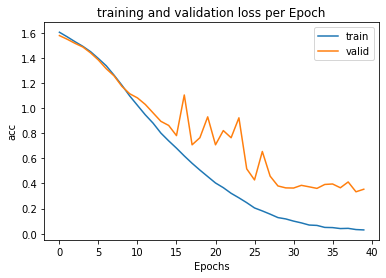

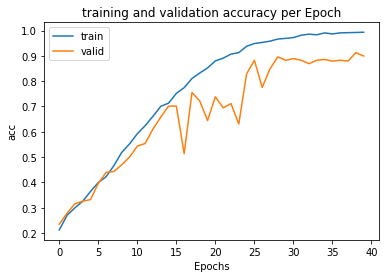

In [ ]:
class DanCnn(nn.Module):
    def __init__(self,vocab_size,embed_dim,seq_len,output_dim):
        super(DanCnn, self).__init__()

        self.embedding = nn.Embedding(vocab_size,embed_dim)

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=100, kernel_size=(3,embed_dim)),
            #nn.BatchNorm2d(200),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(seq_len-2,1), stride=1)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=100, kernel_size=(2,embed_dim)),
            #nn.BatchNorm2d(200),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(seq_len-1,1),stride=1)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(6,embed_dim)),
            #nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(seq_len-5,1),stride=1)
        )
        
        self.fc1 = nn.Linear(in_features=210, out_features=32)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=1000, out_features=500)
        self.fc3 = nn.Linear(in_features=500, out_features=100)
        self.fc4 = nn.Linear(in_features=32, out_features=output_dim)
        
    def forward(self, x):
        # x = [batch, num_sentence, num_words]
        embed = self.embedding(x)
        embed_dan = torch.mean(embed, dim = 2).squeeze(2)
        # embed_da  = [batch, num_sentences, embed_dim]
        out1 = self.layer1(embed_dan).squeeze(-1).squeeze(-1)
        out2= self.layer2(embed_dan).squeeze(-1).squeeze(-1)
        
        out3 = self.layer3(embed_dan).squeeze(-1).squeeze(-1)

        out4 = torch.cat((out1,out2,out3),dim=1)
        
        lin1 = self.fc1(out4)
        '''lin1 = self.drop(lin1)
        lin2 = self.fc2(lin1)
        lin2 = self.drop(lin2)
        lin3 = self.fc3(lin2)'''
        lin3 = self.drop(lin1)
        lin4 = self.fc4(lin3)
        return lin4

embed_dim = 100
vocab_dim = vocab_size
max_sen_length = X_train.shape[1]
num_classes = 5
model = DanCnn(vocab_size=vocab_dim,embed_dim = embed_dim,seq_len=max_sen_length,output_dim=num_classes).to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.0001
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
num_epochs =  40
batch_size = 2
size = X_train.shape[0]
d = int(size/batch_size)
val_size = int(0.2*X_train.shape[0])
X_train_b = np.array_split(X_train[val_size:,:,:],d)
y_train_b = np.array_split(y_train[val_size:],d)
train_loss = []
val_loss = []

X_val = X_train[:val_size,:,:]
y_val = y_train[:val_size] 
X_val1, y_val1 = torch.from_numpy(X_val), torch.from_numpy(y_val)
X_val1, y_val1 = X_val1.to(device).unsqueeze(1), y_val1.to(device)


train_acc = 0
train_accs = []
valid_accs = []
best_ac = 0

for epoch in range(num_epochs):
    
    batch_loss = 0
    n_samples = 0
    train_acc = 0
    
    for X_train1, y_train1 in zip(X_train_b,y_train_b):
        model.train()
        n_samples += X_train1.shape[0]
        X_train1, y_train1 = torch.from_numpy(X_train1), torch.from_numpy(y_train1)
        X_train1, y_train1 = X_train1.to(device).unsqueeze(1), y_train1.to(device)
        
        # Forward pass 
        outputs = model(X_train1.long())
        loss = error(outputs, y_train1)
        batch_loss+=loss*X_train1.shape[0]
        train_acc += torch.sum(y_train1==torch.argmax(outputs,1)) 
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    print("No of epoch: {}, Training Loss: {} Acc: {}".format(epoch, batch_loss/n_samples,train_acc/n_samples))

    model.eval()

    output = model(X_val1.long())
    loss = error(output, y_val1)
    valid_acc = torch.sum(y_val1==torch.argmax(output,1))/y_val1.shape[0]
    print("Validation Loss: {} Acc: {}".format(loss.data,valid_acc))
    train_loss.append(batch_loss/n_samples)
    val_loss.append(loss)
    train_accs.append(train_acc/n_samples)
    valid_accs.append(valid_acc)
    if best_ac<valid_acc:
      best_ac = valid_acc
      torch.save(model,'model_sen2.sav')

# ploting training loss per epochs
  
plt.title('training and validation loss per Epoch')
plt.plot(train_loss,label='train')
plt.plot(val_loss,label='valid')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

plt.title('training and validation accuracy per Epoch')
plt.plot(train_accs,label='train')
plt.plot(valid_accs,label='valid')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

In [13]:
class TransformerCnn(nn.Module):
    def __init__(self,vocab_size,embed_dim,seq_len,output_dim,nheads,nlayers,dropout,device):
        super(TransformerCnn, self).__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size,embed_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model = embed_dim, nhead = nheads, dropout=dropout, batch_first=True, device=device)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        # self.layer1 = nn.Sequential(
        #     nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,embed_dim)),
        #     #nn.BatchNorm2d(200),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=(seq_len-2,1), stride=1)
        # )
        
        # self.layer2 = nn.Sequential(
        #     nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(2,embed_dim)),
        #     #nn.BatchNorm2d(200),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=(seq_len-1,1),stride=1)
        # )
        # self.layer3 = nn.Sequential(
        #     nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(6,embed_dim)),
        #     #nn.BatchNorm2d(100),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=(seq_len-5,1),stride=1)
        # )
        
        self.fc1 = nn.Linear(in_features=100, out_features=5)
        '''self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=1000, out_features=500)
        self.fc3 = nn.Linear(in_features=500, out_features=100)
        self.fc4 = nn.Linear(in_features=100, out_features=output_dim)'''
        
    def forward(self, x):
        # x = [batch, num_sentence, num_words]
        batch_size = x.shape[0]
        para_size = x.shape[1]
        sen_size = x.shape[2]
        embed_dim = self.embed_dim
        embed = self.embedding(x)
        # embed = [batch, num_sentence, num_words, embed_dim]
        embed_trans = embed.reshape(batch_size*para_size,sen_size,embed_dim)
        # embed_trans = [batch*num_sentence, num_words, embed_dim]
        embed_trans = self.transformer_encoder(embed_trans)
        embed_trans = embed_trans.reshape(batch_size,para_size,sen_size,embed_dim)
        # embed_trans = [batch, num_sentence, num_words, embed_dim]
        embed_trans = torch.sum(embed_trans, dim = 2).squeeze(2)
        # embed_trans  = [batch, num_sentences, embed_dim]
        embed_trans = torch.mean(embed_trans,dim = 1).squeeze(1)
        # embed_trans  = [batch, embed_dim]
        # out1 = self.layer1(embed_trans).squeeze(-1).squeeze(-1)
        # out2= self.layer2(embed_trans).squeeze(-1).squeeze(-1)
        # out3 = self.layer3(embed_trans).squeeze(-1).squeeze(-1)

        # out4 = torch.cat((out1,out2,out3),dim=1)
        
        lin1 = self.fc1(embed_trans)
        '''lin1 = self.drop(lin1)
        lin2 = self.fc2(lin1)
        lin2 = self.drop(lin2)
        lin3 = self.fc3(lin2)'''
        # lin3 = self.drop(lin1)
        # lin4 = self.fc4(lin3)
        return lin1

embed_dim = 100
vocab_dim = vocab_size
max_sen_length = X_train.shape[1]
num_classes = 5
n_head = 1
dropout = 0.4
n_layer = 1
model = TransformerCnn(vocab_size = vocab_dim, embed_dim = embed_dim, seq_len = max_sen_length, output_dim = num_classes, nheads = n_head, nlayers = n_layer, dropout = dropout,device=device).to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs =  100
batch_size = 20
size = X_train.shape[0]
d = int(size/batch_size)
val_size = int(0.2*X_train.shape[0])
X_train_b = np.array_split(X_train[val_size:,:,:],d)
y_train_b = np.array_split(y_train[val_size:],d)
train_loss = []
val_loss = []

X_val = X_train[:val_size,:,:]
y_val = y_train[:val_size] 
X_val1, y_val1 = torch.from_numpy(X_val), torch.from_numpy(y_val)
X_val1, y_val1 = X_val1.to(device), y_val1.to(device)
X_train_d, y_train_d = [torch.from_numpy(X_train_b[i]).to(device) for i in range(len(X_train_b))], [torch.from_numpy(y_train_b[i]).to(device) for i in range(len(y_train_b))]

train_acc = 0
train_accs = []
valid_accs = []
best_ac = 0
for epoch in range(num_epochs):
    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model has {count_parameters(model):,} trainable parameters')
    batch_loss = 0
    n_samples = 0
    train_acc = 0
    
    for X_train1, y_train1 in zip(X_train_d,y_train_d):
        model.train()
        n_samples += X_train1.shape[0]
        # X_train1, y_train1 = torch.from_numpy(X_train1), torch.from_numpy(y_train1)
        #X_train1, y_train1 = X_train1.to(device), y_train1.to(device)

        # Forward pass 
        outputs = model(X_train1)
        loss = error(outputs, y_train1)
        batch_loss+=loss*X_train1.shape[0]
        train_acc += torch.sum(y_train1==torch.argmax(outputs,1)) 
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
        torch.cuda.empty_cache()
    print("No of epoch: {}, Training Loss: {} Acc: {}".format(epoch, batch_loss/n_samples,train_acc/n_samples))

    model.eval()

    output = model(X_val1)
    loss = error(output, y_val1)
    valid_acc = torch.sum(y_val1==torch.argmax(output,1))/y_val1.shape[0]
    print("Validation Loss: {} Acc: {}".format(loss.data,valid_acc))
    train_loss.append(batch_loss/n_samples)
    val_loss.append(loss)
    train_accs.append(train_acc/n_samples)
    valid_accs.append(valid_acc)
    if best_ac<valid_acc:
      best_ac = valid_acc
      torch.save(model,'model_sen2.sav')

# ploting training loss per epochs
  
plt.title('training and validation loss per Epoch')
plt.plot(train_loss,label='train')
plt.plot(val_loss,label='valid')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

plt.title('training and validation accuracy per Epoch')
plt.plot(train_accs,label='train')
plt.plot(valid_accs,label='valid')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

The model has 2,883,053 trainable parameters
No of epoch: 0, Training Loss: 2.3601560592651367 Acc: 0.2625838816165924
Validation Loss: 1.5271942615509033 Acc: 0.33557048439979553
The model has 2,883,053 trainable parameters
No of epoch: 1, Training Loss: 1.759210228919983 Acc: 0.3162751793861389
Validation Loss: 1.3948886394500732 Acc: 0.43959730863571167
The model has 2,883,053 trainable parameters
No of epoch: 2, Training Loss: 1.6073168516159058 Acc: 0.3850671052932739


RuntimeError: ignored

In [ ]:
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
src = torch.rand(2,3,4,4)
print(src)
src.reshape(6,4,4)


tensor([[[[0.8936, 0.3621, 0.0365, 0.4628],
          [0.7752, 0.8120, 0.5174, 0.2195],
          [0.1159, 0.2384, 0.1707, 0.1345],
          [0.1033, 0.1419, 0.0236, 0.1205]],

         [[0.9250, 0.3418, 0.5556, 0.1791],
          [0.0748, 0.3209, 0.0501, 0.3025],
          [0.7024, 0.9437, 0.6606, 0.2848],
          [0.4811, 0.3641, 0.3996, 0.8863]],

         [[0.5839, 0.7430, 0.0227, 0.1504],
          [0.4039, 0.7355, 0.4512, 0.7449],
          [0.0460, 0.0767, 0.6493, 0.7810],
          [0.8521, 0.3187, 0.2163, 0.7781]]],


        [[[0.4023, 0.2004, 0.2354, 0.2102],
          [0.3068, 0.1624, 0.2779, 0.2119],
          [0.2251, 0.4851, 0.3221, 0.0149],
          [0.4167, 0.3402, 0.6042, 0.7462]],

         [[0.9133, 0.1600, 0.0038, 0.2284],
          [0.4056, 0.9389, 0.9815, 0.1131],
          [0.5727, 0.8814, 0.1339, 0.6103],
          [0.8746, 0.8148, 0.6361, 0.7126]],

         [[0.5536, 0.0291, 0.8081, 0.6539],
          [0.8771, 0.1778, 0.3848, 0.2608],
          [0.3986, 0

tensor([[[0.8936, 0.3621, 0.0365, 0.4628],
         [0.7752, 0.8120, 0.5174, 0.2195],
         [0.1159, 0.2384, 0.1707, 0.1345],
         [0.1033, 0.1419, 0.0236, 0.1205]],

        [[0.9250, 0.3418, 0.5556, 0.1791],
         [0.0748, 0.3209, 0.0501, 0.3025],
         [0.7024, 0.9437, 0.6606, 0.2848],
         [0.4811, 0.3641, 0.3996, 0.8863]],

        [[0.5839, 0.7430, 0.0227, 0.1504],
         [0.4039, 0.7355, 0.4512, 0.7449],
         [0.0460, 0.0767, 0.6493, 0.7810],
         [0.8521, 0.3187, 0.2163, 0.7781]],

        [[0.4023, 0.2004, 0.2354, 0.2102],
         [0.3068, 0.1624, 0.2779, 0.2119],
         [0.2251, 0.4851, 0.3221, 0.0149],
         [0.4167, 0.3402, 0.6042, 0.7462]],

        [[0.9133, 0.1600, 0.0038, 0.2284],
         [0.4056, 0.9389, 0.9815, 0.1131],
         [0.5727, 0.8814, 0.1339, 0.6103],
         [0.8746, 0.8148, 0.6361, 0.7126]],

        [[0.5536, 0.0291, 0.8081, 0.6539],
         [0.8771, 0.1778, 0.3848, 0.2608],
         [0.3986, 0.5187, 0.5226, 0.7373],
 

In [ ]:
src

tensor([[[[0.8936, 0.3621, 0.0365, 0.4628],
          [0.7752, 0.8120, 0.5174, 0.2195],
          [0.1159, 0.2384, 0.1707, 0.1345],
          [0.1033, 0.1419, 0.0236, 0.1205]],

         [[0.9250, 0.3418, 0.5556, 0.1791],
          [0.0748, 0.3209, 0.0501, 0.3025],
          [0.7024, 0.9437, 0.6606, 0.2848],
          [0.4811, 0.3641, 0.3996, 0.8863]],

         [[0.5839, 0.7430, 0.0227, 0.1504],
          [0.4039, 0.7355, 0.4512, 0.7449],
          [0.0460, 0.0767, 0.6493, 0.7810],
          [0.8521, 0.3187, 0.2163, 0.7781]]],


        [[[0.4023, 0.2004, 0.2354, 0.2102],
          [0.3068, 0.1624, 0.2779, 0.2119],
          [0.2251, 0.4851, 0.3221, 0.0149],
          [0.4167, 0.3402, 0.6042, 0.7462]],

         [[0.9133, 0.1600, 0.0038, 0.2284],
          [0.4056, 0.9389, 0.9815, 0.1131],
          [0.5727, 0.8814, 0.1339, 0.6103],
          [0.8746, 0.8148, 0.6361, 0.7126]],

         [[0.5536, 0.0291, 0.8081, 0.6539],
          [0.8771, 0.1778, 0.3848, 0.2608],
          [0.3986, 0

In [ ]:
src.reshape(2,3,4,4)

tensor([[[[0.8936, 0.3621, 0.0365, 0.4628],
          [0.7752, 0.8120, 0.5174, 0.2195],
          [0.1159, 0.2384, 0.1707, 0.1345],
          [0.1033, 0.1419, 0.0236, 0.1205]],

         [[0.9250, 0.3418, 0.5556, 0.1791],
          [0.0748, 0.3209, 0.0501, 0.3025],
          [0.7024, 0.9437, 0.6606, 0.2848],
          [0.4811, 0.3641, 0.3996, 0.8863]],

         [[0.5839, 0.7430, 0.0227, 0.1504],
          [0.4039, 0.7355, 0.4512, 0.7449],
          [0.0460, 0.0767, 0.6493, 0.7810],
          [0.8521, 0.3187, 0.2163, 0.7781]]],


        [[[0.4023, 0.2004, 0.2354, 0.2102],
          [0.3068, 0.1624, 0.2779, 0.2119],
          [0.2251, 0.4851, 0.3221, 0.0149],
          [0.4167, 0.3402, 0.6042, 0.7462]],

         [[0.9133, 0.1600, 0.0038, 0.2284],
          [0.4056, 0.9389, 0.9815, 0.1131],
          [0.5727, 0.8814, 0.1339, 0.6103],
          [0.8746, 0.8148, 0.6361, 0.7126]],

         [[0.5536, 0.0291, 0.8081, 0.6539],
          [0.8771, 0.1778, 0.3848, 0.2608],
          [0.3986, 0